In [2]:
import pandas as pd
import math
from sklearn.model_selection import KFold
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

In [9]:
#metrics computed on the test set
from sklearn.metrics import classification_report
def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            labels=[0,1]))

### Pre-processing dati
Leggo e normalizzo i dati dal training set (80% del dataset di partenza), inoltre isolo solo le feature che potrebbero essere utili per la previsione del numero di morti

In [5]:
def get_normalized_dataset(input: str, output: str,scale=True):
    input = pd.read_csv(input)
    output = pd.read_csv(output)
    df = pd.merge(input, output, left_index=True, right_index=True)

    selected_collumns = ['n_injured', 'n_arrested', 'n_unharmed', 'n_participants']

    df = df[selected_collumns + ['killed']]
    df.dropna(inplace=True)

    input = df[selected_collumns].values
    output = df['killed'].values
    if scale:
        # Normalizza i dati
        scaler = StandardScaler()
        input = scaler.fit_transform(input) 
    
    
    return input, output

input, output = get_normalized_dataset("training/input.csv","training/output.csv")


In [15]:
Testinput, Testoutput = get_normalized_dataset("testing/input.csv","testing/output.csv")
scaler = StandardScaler()

# K-nn
Uso k-fold cross validation per trovare il miglior parametro k per l'algoritmo e perchè i dati non sono equamente distribuiti tra le diverse classi
Come rule of thumb si prende:
$$
K = \sqrt{N}
$$
N è la cardinalità del training set.

In [23]:
from sklearn.neighbors import KNeighborsClassifier
kfold = KFold(n_splits=5, shuffle=True, random_state=42)


In [26]:
temp= int(math.sqrt(len(input)))
X_print=[]
Y_print=[]
for i in (np.arange(11)):
    N= int(temp *(0.5+0.1*i))
    X_print.append(N)
    knn = KNeighborsClassifier(n_neighbors=N, algorithm='ball_tree', metric='minkowski')
    Y_print.append(cross_val_score(knn,input,output,cv=kfold).mean())
    print(f"{i+1}/11",end="\r")

plt.plot(X_print,Y_print)
plt.show()

AttributeError: module 'matplotlib' has no attribute 'plot'

All'aumentare di N, il modello risulta essere meno sensibile al noise ma anche meno capace di generalizzare.

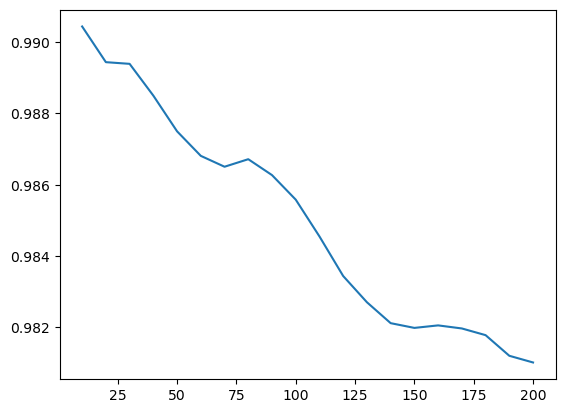

In [30]:
#prvo a ridurre ancora N
temp= int(math.sqrt(len(input)))
X_print=[]
Y_print=[]
for i in np.arange(10,201,10):
    N= i
    X_print.append(N)
    knn = KNeighborsClassifier(n_neighbors=N, algorithm='ball_tree', metric='minkowski')
    Y_print.append(cross_val_score(knn,input,output,cv=kfold).mean())
    print(f"{i+1}",end="\r")

plt.plot(X_print,Y_print,label="accuracy")
plt.show()

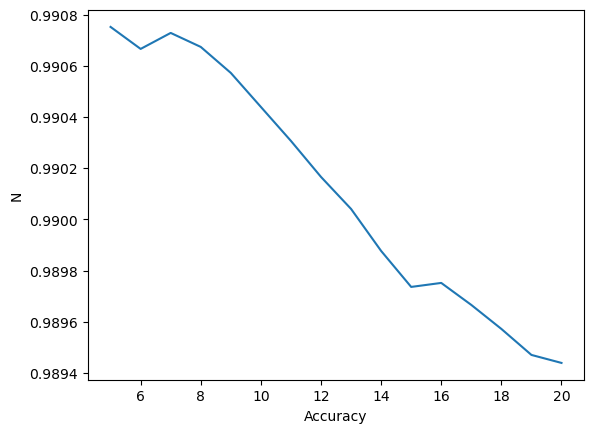

In [35]:
#prvo a ridurre ancora N
temp= int(math.sqrt(len(input)))
X_print=[]
Y_print=[]
for i in np.arange(5, 21,1):
    N= i
    X_print.append(N)
    knn = KNeighborsClassifier(n_neighbors=N, algorithm='ball_tree', metric='minkowski')
    Y_print.append(cross_val_score(knn,input,output,cv=kfold).mean())
    print(f"{i+1}",end="\r")

plt.plot(X_print,Y_print)
plt.xlabel('Accuracy')
plt.ylabel('N')
plt.show()

Da evidenze grafiche si sceglie K = 50 in quanto mantiene buon livello di accuracy e buona restistenza da noise data.
Valori minori per K avrebbero mlta meno tolleranza di noise data, mantenendo praticamente la stessa accuracy.
Di seguito si esegue training e testing sul miglior modello trovato

In [36]:
K= 50
knn= KNeighborsClassifier(n_neighbors=N, algorithm='ball_tree', metric='minkowski').fit(input,output)
test_pred_knn = knn.predict(scaler.fit_transform(Testinput))
report_scores(Testoutput,test_pred_knn)

              precision    recall  f1-score   support

        <=50       0.99      0.99      0.99     23305
         >50       0.97      0.98      0.98      8656

    accuracy                           0.99     31961
   macro avg       0.98      0.99      0.99     31961
weighted avg       0.99      0.99      0.99     31961



# Naive Bayesian Classification
Non ha senso in questo caso normalizzare o usare k-fold

In [10]:
#import, define and fit the model
from sklearn.naive_bayes import GaussianNB
trInput,trOutput = get_normalized_dataset("training/input.csv","training/output.csv",scale=False)
testInput,testOutput = get_normalized_dataset("testing/input.csv","testing/output.csv",scale=False)
gnb = GaussianNB()
gnb.fit(trInput,trOutput)

#predict on the test set
test_pred_gnb = gnb.predict(testInput)
#compute the performance of the model
report_scores(testOutput,test_pred_gnb)

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     23305
           1       1.00      0.69      0.82      8656

    accuracy                           0.92     31961
   macro avg       0.95      0.84      0.88     31961
weighted avg       0.92      0.92      0.91     31961



Dal **Recall** sembrerebbe che il classificatore non riesca a cogliere le caratteristiche della classe 1, non classificando il 30% delle istanze di classe 1 nella classe 1.

# Classification with rule based
Verifichiamo la migliore coppia **(K, prune_size)** attraverso gridSearch.<br>
Ricordiamo che sia per k e pruneSize, valori minori a parità di prestazioni, sono da preferire, perchè nè corrispondono modelli più semplici.


In [13]:
from sklearn.model_selection import GridSearchCV
import wittgenstein as lw
trInput,trOutput = get_normalized_dataset("training/input.csv","training/output.csv",scale=False)
testInput,testOutput = get_normalized_dataset("testing/input.csv","testing/output.csv",scale=False)
ripper = lw.RIPPER()
param_grid = {"prune_size": [0.5, 0.6], "k": [1, 3, 5]}
grid_search = GridSearchCV(estimator=ripper, param_grid=param_grid,verbose=2)
grid_search.fit(trInput,trOutput)
print('Best parameters setting ', grid_search.cv_results_['params'][0])

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ................................k=1, prune_size=0.5; total time=  52.7s
[CV] END ................................k=1, prune_size=0.5; total time=  57.6s
[CV] END ................................k=1, prune_size=0.5; total time=  55.5s
[CV] END ................................k=1, prune_size=0.5; total time=  56.0s
[CV] END ................................k=1, prune_size=0.5; total time=  56.0s
[CV] END ................................k=1, prune_size=0.6; total time=  55.9s
[CV] END ................................k=1, prune_size=0.6; total time=  52.6s
[CV] END ................................k=1, prune_size=0.6; total time=  52.0s
[CV] END ................................k=1, prune_size=0.6; total time=  55.4s
[CV] END ................................k=1, prune_size=0.6; total time=  59.3s
[CV] END ................................k=3, prune_size=0.5; total time=  54.8s
[CV] END ................................k=3, pru

In [23]:
grid_search.cv_results_

{'mean_fit_time': array([55.52221646, 55.01625986, 53.83497529, 53.58290458, 56.46879244,
        55.77721615]),
 'std_fit_time': array([1.58921749, 2.61476977, 1.79734279, 2.0139219 , 4.78508458,
        2.61158497]),
 'mean_score_time': array([0.12417822, 0.12001534, 0.12279935, 0.12188721, 0.12417016,
        0.12033553]),
 'std_score_time': array([0.0043384 , 0.00331021, 0.00074864, 0.00389007, 0.00526043,
        0.00288787]),
 'param_k': masked_array(data=[1, 1, 3, 3, 5, 5],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_prune_size': masked_array(data=[0.5, 0.6, 0.5, 0.6, 0.5, 0.6],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'k': 1, 'prune_size': 0.5},
  {'k': 1, 'prune_size': 0.6},
  {'k': 3, 'prune_size': 0.5},
  {'k': 3, 'prune_size': 0.6},
  {'k': 5, 'prune_size': 0.5},
  {'k': 5, 'prune_size': 0.6}],
 'split0_test_sc

In [21]:
grid_search.best_params_

{'k': 1, 'prune_size': 0.5}

Training modello sugli hyperparametri ottimali che abbiamo trovato con gridSearch

In [46]:
#define and fit the rule-based model
#this function requires only one dataset with the labels. 
#To do so, we concatenate the train_set and the train_label

ripper = lw.RIPPER(k=1, prune_size=0.5)
datas = pd.concat([pd.DataFrame(trInput,columns= ['n_injured', 'n_arrested', 'n_unharmed', 'n_participants']),pd.DataFrame(trOutput,columns= ['killed'])], axis=1)
ripper.fit(datas,class_feat='killed', pos_class=1)

In [47]:
test_pred_gnb = ripper.predict(pd.DataFrame(testInput,columns= ['n_injured', 'n_arrested', 'n_unharmed', 'n_participants']))
#compute the performance of the model
report_scores(testOutput,test_pred_gnb)

              precision    recall  f1-score   support

           0       0.74      0.87      0.80     23305
           1       0.34      0.18      0.24      8656

    accuracy                           0.68     31961
   macro avg       0.54      0.53      0.52     31961
weighted avg       0.63      0.68      0.65     31961



In [48]:
#in this case the model is a set of rules
ripper.out_model()

[[n_unharmed=<1.0 ^ n_participants=2.0-3.0 ^ n_injured=<1.0 ^ n_arrested=<1.0] V
[n_unharmed=<1.0 ^ n_injured=<1.0 ^ n_participants=>3.0 ^ n_arrested=<1.0] V
[n_participants=>3.0 ^ n_unharmed=<1.0 ^ n_arrested=<1.0] V
[n_participants=>3.0 ^ n_unharmed=<1.0 ^ n_injured=<1.0] V
[n_participants=2.0-3.0 ^ n_arrested=>1.0 ^ n_injured=<1.0] V
[n_participants=2.0-3.0 ^ n_injured=>1.0 ^ n_arrested=<1.0] V
[n_participants=>3.0 ^ n_unharmed=<1.0] V
[n_participants=>3.0 ^ n_injured=<1.0 ^ n_arrested=<1.0] V
[n_participants=2.0-3.0 ^ n_injured=<1.0] V
[n_participants=>3.0 ^ n_arrested=<1.0] V
[n_participants=>3.0 ^ n_injured=<1.0] V
[n_participants=>3.0]]
